In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tcn import TCN

In [4]:
!pip install keras-tcn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 16.4 MB/s eta 0:00:0000:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
ydata-profiling 4.10.0 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.


In [5]:
!pip install --upgrade tensorflow



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's d

In [7]:
# Paths to directories (update these paths to Kaggle after uploading)
train_dir = '/kaggle/input/crowd-survillance-annoted-frames/final_frames/train'  # Update to your train directory
val_dir = '/kaggle/input/crowd-survillance-annoted-frames/final_frames/validation'  # Update to your validation directory
test_dir =  '/kaggle/input/crowd-survillance-annoted-frames/final_frames/test'


In [8]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def pad_and_normalize(image):
    # Pad the image if necessary (for example, if you want to maintain aspect ratio)
    target_size = (224, 224)
    padded_image = np.zeros((target_size[0], target_size[1], 3), dtype=image.dtype)
    
    # Compute padding sizes
    h, w, _ = image.shape
    pad_h = (target_size[0] - h) // 2
    pad_w = (target_size[1] - w) // 2

    # Fill the padded area with the original image
    padded_image[pad_h:pad_h + h, pad_w:pad_w + w, :] = image
    
    # Normalize the image
    normalized_image = padded_image / 255.0
    
    return normalized_image


In [9]:
batch_size = 32
image_size = (224, 224)

train_datagen = ImageDataGenerator(
    preprocessing_function=pad_and_normalize,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=pad_and_normalize
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 23491 images belonging to 2 classes.
Found 4150 images belonging to 2 classes.


In [10]:
# Print class indices
print("Class indices (train):", train_generator.class_indices)
print("Class indices (validation):", val_generator.class_indices)

# Get the number of classes
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)


Class indices (train): {'non_violence': 0, 'violence': 1}
Class indices (validation): {'non_violence': 0, 'violence': 1}
Number of classes: 2


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout, Flatten, Dense, InputLayer
from tensorflow.keras import regularizers

def build_tcn_model(shape):
    model = Sequential()
    model.add(InputLayer(shape=shape))
    
    # First TCN Layer with L2 regularization
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Second TCN Layer with added L2 regularization
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    # Flatten and output layers
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # For binary classification

    return model

# Define shape for the images
shape = (224, 224, 3)  # RGB images
tcn_model = build_tcn_model(shape)

# Compile the model with binary crossentropy loss and Adam optimizer
tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model without early stopping
epochs = 10  # Define your number of epochs

history = tcn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730824822.640331     123 service.cc:145] XLA service 0x7e493c005650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730824822.640377     123 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/734 ━━━━━━━━━━━━━━━━━━━━ 3:39:51 18s/step - accuracy: 0.5000 - loss: 1.6345

I0000 00:00:1730824833.111157     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


734/734 ━━━━━━━━━━━━━━━━━━━━ 550s 726ms/step - accuracy: 0.7959 - loss: 53.7294 - val_accuracy: 0.8537 - val_loss: 18.6250
Epoch 2/10
  1/734 ━━━━━━━━━━━━━━━━━━━━ 1:49 149ms/step - accuracy: 0.9375 - loss: 7.4104

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


734/734 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9375 - loss: 7.4104 - val_accuracy: 0.7727 - val_loss: 25.8657
Epoch 3/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 332s 448ms/step - accuracy: 0.8795 - loss: 18.5064 - val_accuracy: 0.9319 - val_loss: 4.4224
Epoch 4/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 78us/step - accuracy: 0.8750 - loss: 16.2262 - val_accuracy: 0.9545 - val_loss: 1.7447
Epoch 5/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 324s 437ms/step - accuracy: 0.9545 - loss: 4.6215 - val_accuracy: 0.8156 - val_loss: 19.2109
Epoch 6/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 78us/step - accuracy: 0.9062 - loss: 5.9442 - val_accuracy: 0.6818 - val_loss: 46.4543
Epoch 7/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 323s 436ms/step - accuracy: 0.9691 - loss: 3.3886 - val_accuracy: 0.9588 - val_loss: 4.6440
Epoch 8/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 0s 77us/step - accuracy: 0.9688 - loss: 2.1857 - val_accuracy: 1.0000 - val_loss: 1.0927
Epoch 9/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 321s 433ms/step - accuracy: 0.9626 - loss: 5.5772 - val

In [12]:
# Data generators
test_datagen = ImageDataGenerator(
    preprocessing_function=pad_and_normalize
)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Change to your actual test directory
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',  # Use 'categorical' for multi-class classification
    shuffle=False  # Important for evaluation
)


Found 4784 images belonging to 2 classes.


In [13]:
# Evaluate the model on the test set
# Make predictions
y_true = test_generator.classes  # True labels
y_pred_prob = tcn_model.predict(test_generator)  # Get predicted probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions


150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 348ms/step


Found 4784 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step
Confusion Matrix:
 [[2437    2]
 [ 175 2170]]
Classification Report:
               precision    recall  f1-score   support

Non-violence       0.93      1.00      0.96      2439
    Violence       1.00      0.93      0.96      2345

    accuracy                           0.96      4784
   macro avg       0.97      0.96      0.96      4784
weighted avg       0.97      0.96      0.96      4784



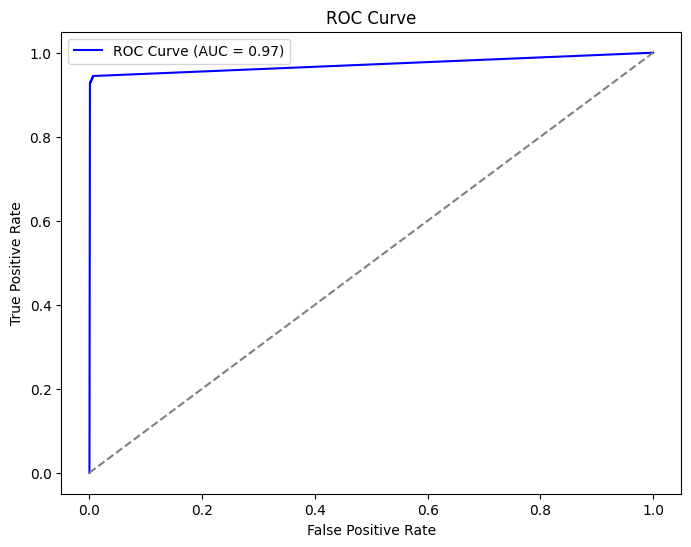

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Generate predictions and true labels for the test set
test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Important for consistent ordering
)

# Predict the probabilities for the test data
pred_probs = tcn_model.predict(test_generator)
pred_classes = (pred_probs > 0.5).astype(int)  # Convert probabilities to binary classes
true_classes = test_generator.classes  # True labels

# 2. Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)
print("Confusion Matrix:\n", cm)

# 3. Classification Report
class_report = classification_report(true_classes, pred_classes, target_names=['Non-violence', 'Violence'])
print("Classification Report:\n", class_report)

# 4. AUC-ROC Curve
roc_auc = roc_auc_score(true_classes, pred_probs)
fpr, tpr, thresholds = roc_curve(true_classes, pred_probs)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



In [26]:
tcn_model.save('/kaggle/working/SafeVision_tcn_model.h5')


In [23]:
# Load your trained model
tcn_model = tf.keras.models.load_model('/kaggle/working/SafeVision_tcn_model.h5')  # Adjust path


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2439
           1       1.00      0.93      0.96      2345

    accuracy                           0.96      4784
   macro avg       0.97      0.96      0.96      4784
weighted avg       0.97      0.96      0.96      4784



Confusion Matrix:
[[2437    2]
 [ 175 2170]]


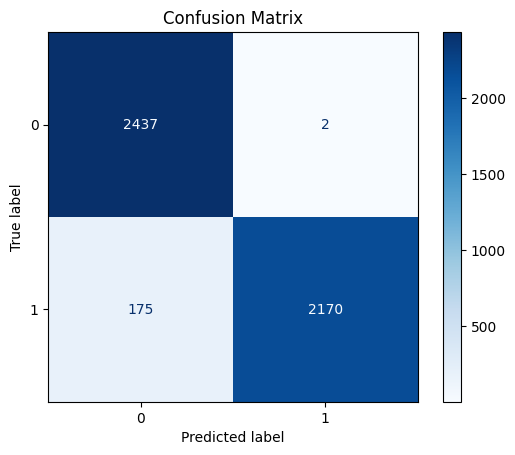

In [18]:
import matplotlib.pyplot as plt
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay  # Ensure this import is included
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


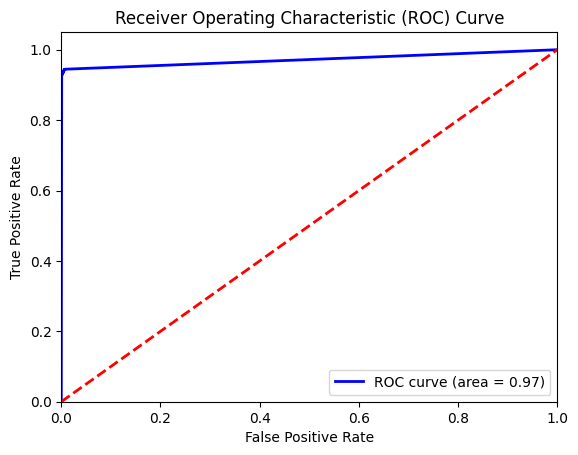

In [19]:
# Calculate and plot AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [20]:
video_path="/kaggle/input/violence-videos/V_999.mp4"

In [3]:
!pip install mediapipe



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 46.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires protobuf<4,>3.12.2, but you have protobuf 4.25.5 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is inc

In [22]:
import numpy as np
import cv2
import tensorflow as tf
import random

def pad_and_normalize(image):
    # Pad the image to maintain aspect ratio
    target_size = (224, 224)
    padded_image = np.zeros((target_size[0], target_size[1], 3), dtype=image.dtype)
    
    # Compute padding sizes
    h, w, _ = image.shape
    pad_h = (target_size[0] - h) // 2
    pad_w = (target_size[1] - w) // 2

    # Fill the padded area with the original image
    padded_image[pad_h:pad_h + h, pad_w:pad_w + w, :] = image
    
    # Normalize the image
    normalized_image = padded_image / 255.0
    
    return normalized_image

def augment_frame(frame):
    # Randomly apply augmentations to the frame
    angle = random.uniform(-20, 20)
    height, width = frame.shape[:2]
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    frame = cv2.warpAffine(frame, M, (width, height))

    tx = random.uniform(-width * 0.2, width * 0.2)
    ty = random.uniform(-height * 0.2, height * 0.2)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    frame = cv2.warpAffine(frame, M, (width, height))

    if random.random() > 0.5:
        frame = cv2.flip(frame, 1)
    
    # Ensure final size is 224x224 after all augmentations
    frame = cv2.resize(frame, (224, 224))
    return frame

def predict_violence(video_path, model, threshold=0.5):
    cap = cv2.VideoCapture(video_path)
    violence_count = 0
    non_violence_count = 0
    frame_number = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_number += 1
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_resized = cv2.resize(frame, (224, 224))

        # Apply augmentation (optional)
        augmented_frame = augment_frame(frame_resized)
        
        # Preprocess frame
        frame_array = pad_and_normalize(augmented_frame)
        frame_array = np.expand_dims(frame_array, axis=0)

        # Predict violence probability
        prediction = model.predict(frame_array)[0][0]
        
        # Classify based on threshold and count
        if prediction >= threshold:
            print(f"Frame {frame_number}: Violence detected (Score: {prediction:.2f})")
            violence_count += 1
        else:
            print(f"Frame {frame_number}: Non-violence detected (Score: {prediction:.2f})")
            non_violence_count += 1

    cap.release()
    
    print(f"\nTotal violence frames: {violence_count}")
    print(f"Total non-violence frames: {non_violence_count}")

# Load the trained model
tcn_model = tf.keras.models.load_model('/kaggle/working/SafeVision_tcn_model.h5')

# Run the prediction
video_path = '/kaggle/input/non-violence-videos/NV_996.mp4'
predict_violence(video_path, tcn_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Frame 1: Violence detected (Score: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Frame 2: Non-violence detected (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Frame 3: Non-violence detected (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 4: Non-violence detected (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 5: Non-violence detected (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 6: Non-violence detected (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 7: Non-violence detected (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 8: Violence detected (Score: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 9: Non-violence detected (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Frame 10: Non-violence detected (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 11: Violence detected (Score: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 12: Violence detected (Score: 0.83)
1/1 ━━━━━━━━━━━━

In [6]:
import numpy as np
import cv2
import tensorflow as tf
import random
import mediapipe as mp

# Initialize MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

def pad_and_normalize(image):
    # Pad the image to maintain aspect ratio
    target_size = (224, 224)
    padded_image = np.zeros((target_size[0], target_size[1], 3), dtype=image.dtype)
    
    # Compute padding sizes
    h, w, _ = image.shape
    pad_h = (target_size[0] - h) // 2
    pad_w = (target_size[1] - w) // 2

    # Fill the padded area with the original image
    padded_image[pad_h:pad_h + h, pad_w:pad_w + w, :] = image
    
    # Normalize the image
    normalized_image = padded_image / 255.0
    
    return normalized_image

def augment_frame(frame):
    # Randomly apply augmentations to the frame
    angle = random.uniform(-20, 20)
    height, width = frame.shape[:2]
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    frame = cv2.warpAffine(frame, M, (width, height))

    tx = random.uniform(-width * 0.2, width * 0.2)
    ty = random.uniform(-height * 0.2, height * 0.2)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    frame = cv2.warpAffine(frame, M, (width, height))

    if random.random() > 0.5:
        frame = cv2.flip(frame, 1)
    
    # Ensure final size is 224x224 after all augmentations
    frame = cv2.resize(frame, (224, 224))
    return frame

def extract_pose_keypoints(frame):
    # Use MediaPipe to detect pose and extract keypoints
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)
    
    # Collect keypoints if pose is detected
    keypoints = []
    if result.pose_landmarks:
        for landmark in result.pose_landmarks.landmark:
            keypoints.append([landmark.x, landmark.y, landmark.z, landmark.visibility])
    else:
        keypoints = None  # No keypoints detected
    return keypoints

def predict_violence(video_path, model, threshold=0.5):
    cap = cv2.VideoCapture(video_path)
    violence_count = 0
    non_violence_count = 0
    frame_number = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_number += 1
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_resized = cv2.resize(frame, (224, 224))

        # Apply augmentation (optional)
        augmented_frame = augment_frame(frame_resized)
        
        # Preprocess frame for TCN model
        frame_array = pad_and_normalize(augmented_frame)
        frame_array = np.expand_dims(frame_array, axis=0)

        # Predict violence probability
        prediction = model.predict(frame_array)[0][0]
        
        # Extract pose keypoints with MediaPipe
        keypoints = extract_pose_keypoints(frame_resized)
        
        if keypoints:
            print(f"Frame {frame_number}: Pose keypoints extracted. Total keypoints: {len(keypoints)}")
        else:
            print(f"Frame {frame_number}: No pose keypoints detected.")
        
        # Classify based on threshold and count
        if prediction >= threshold:
            print(f"Frame {frame_number}: Violence detected (Score: {prediction:.2f})")
            violence_count += 1
        else:
            print(f"Frame {frame_number}: Non-violence detected (Score: {prediction:.2f})")
            non_violence_count += 1

    cap.release()
    
    print(f"\nTotal violence frames: {violence_count}")
    print(f"Total non-violence frames: {non_violence_count}")

# Load the trained model
tcn_model = tf.keras.models.load_model('/kaggle/input/tcn/keras/default/1/SafeVision_tcn_model.h5')

# Run the prediction
video_path = '/kaggle/input/non-violence-videos/NV_998.mp4'
predict_violence(video_path, tcn_model)


W0000 00:00:1730951285.332916    1392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730951285.380600    1392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Frame 1: Pose keypoints extracted. Total keypoints: 33
Frame 1: Non-violence detected (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 2: Pose keypoints extracted. Total keypoints: 33
Frame 2: Non-violence detected (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 3: Pose keypoints extracted. Total keypoints: 33
Frame 3: Violence detected (Score: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Frame 4: Pose keypoints extracted. Total keypoints: 33
Frame 4: Non-violence detected (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 5: Pose keypoints extracted. Total keypoints: 33
Frame 5: Non-violence detected (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 6: Pose keypoints extracted. Total keypoints: 33
Frame 6: Non-violence detected (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Frame 7: Pose keypoints extracted. Total keypoints: 33
Frame 7: Non-violence detected (Score: 0.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

In [9]:
import numpy as np
import cv2
import tensorflow as tf
import random
import mediapipe as mp

# Initialize MediaPipe Pose model with lower detection confidence
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.3, min_tracking_confidence=0.3)

def pad_and_normalize(image):
    target_size = (224, 224)
    padded_image = np.zeros((target_size[0], target_size[1], 3), dtype=image.dtype)
    h, w, _ = image.shape
    pad_h = (target_size[0] - h) // 2
    pad_w = (target_size[1] - w) // 2
    padded_image[pad_h:pad_h + h, pad_w:pad_w + w, :] = image
    normalized_image = padded_image / 255.0
    return normalized_image

def augment_frame(frame):
    angle = random.uniform(-20, 20)
    height, width = frame.shape[:2]
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    frame = cv2.warpAffine(frame, M, (width, height))
    tx = random.uniform(-width * 0.2, width * 0.2)
    ty = random.uniform(-height * 0.2, height * 0.2)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    frame = cv2.warpAffine(frame, M, (width, height))
    if random.random() > 0.5:
        frame = cv2.flip(frame, 1)
    frame = cv2.resize(frame, (224, 224))
    return frame

def extract_pose_keypoints(frame):
    # Ensure input is RGB for MediaPipe
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)
    
    keypoints = []
    if result.pose_landmarks:
        for landmark in result.pose_landmarks.landmark:
            keypoints.append([landmark.x, landmark.y, landmark.z, landmark.visibility])
    else:
        keypoints = None
    return keypoints

def predict_violence(video_path, model, threshold=0.5):
    cap = cv2.VideoCapture(video_path)
    violence_count = 0
    non_violence_count = 0
    frame_number = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_number += 1

        # Extract pose keypoints with MediaPipe
        keypoints = extract_pose_keypoints(frame)
        
        if keypoints:
            print(f"Frame {frame_number}: Pose keypoints extracted. Total keypoints: {len(keypoints)}")
        else:
            print(f"Frame {frame_number}: No pose keypoints detected.")
        
        # Preprocess frame for TCN model
        frame_resized = cv2.resize(frame, (224, 224))
        augmented_frame = augment_frame(frame_resized)
        frame_array = pad_and_normalize(augmented_frame)
        frame_array = np.expand_dims(frame_array, axis=0)

        # Predict violence probability
        prediction = model.predict(frame_array)[0][0]
        
        # Classify based on threshold and count
        if prediction >= threshold:
            print(f"Frame {frame_number}: Violence detected (Score: {prediction:.2f})")
            violence_count += 1
        else:
            print(f"Frame {frame_number}: Non-violence detected (Score: {prediction:.2f})")
            non_violence_count += 1

    cap.release()
    
    print(f"\nTotal violence frames: {violence_count}")
    print(f"Total non-violence frames: {non_violence_count}")

# Load the trained model
tcn_model = tf.keras.models.load_model('/kaggle/input/tcn/keras/default/1/SafeVision_tcn_model.h5')

# Run the prediction
video_path = '/kaggle/input/violence-videos/V_995.mp4'
predict_violence(video_path, tcn_model)


W0000 00:00:1730951479.985649    3896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730951480.040810    3899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Frame 1: No pose keypoints detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Frame 1: Non-violence detected (Score: 0.00)
Frame 2: Pose keypoints extracted. Total keypoints: 33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 2: Violence detected (Score: 1.00)
Frame 3: No pose keypoints detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Frame 3: Violence detected (Score: 1.00)
Frame 4: No pose keypoints detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 4: Violence detected (Score: 1.00)
Frame 5: Pose keypoints extracted. Total keypoints: 33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Frame 5: Violence detected (Score: 1.00)
Frame 6: Pose keypoints extracted. Total keypoints: 33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Frame 6: Non-violence detected (Score: 0.00)
Frame 7: Pose keypoints extracted. Total keypoints: 33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Frame 7: Violence detected (Score: 1.00)
Frame 8: Pose keypoints extracted. Total keypoints: 33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Frame 8: Non-v

In [13]:
!pip install opencv-python

In [14]:
import numpy as np
import cv2
import tensorflow as tf
import random
import mediapipe as mp

# Initialize MediaPipe Pose model and drawing utilities
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.3, min_tracking_confidence=0.3)

def pad_and_normalize(image):
    target_size = (224, 224)
    padded_image = np.zeros((target_size[0], target_size[1], 3), dtype=image.dtype)
    h, w, _ = image.shape
    pad_h = (target_size[0] - h) // 2
    pad_w = (target_size[1] - w) // 2
    padded_image[pad_h:pad_h + h, pad_w:pad_w + w, :] = image
    normalized_image = padded_image / 255.0
    return normalized_image

def augment_frame(frame):
    angle = random.uniform(-20, 20)
    height, width = frame.shape[:2]
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    frame = cv2.warpAffine(frame, M, (width, height))
    tx = random.uniform(-width * 0.2, width * 0.2)
    ty = random.uniform(-height * 0.2, height * 0.2)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    frame = cv2.warpAffine(frame, M, (width, height))
    if random.random() > 0.5:
        frame = cv2.flip(frame, 1)
    frame = cv2.resize(frame, (224, 224))
    return frame

def extract_and_draw_pose(frame):
    # Ensure input is RGB for MediaPipe
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)
    
    if result.pose_landmarks:
        # Draw pose landmarks on the original frame
        mp_drawing.draw_landmarks(frame, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    return frame, result.pose_landmarks

def predict_violence(video_path, model, threshold=0.5):
    cap = cv2.VideoCapture(video_path)
    violence_count = 0
    non_violence_count = 0
    frame_number = 0
    
    # Define the codec and create VideoWriter object
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (frame_width, frame_height))
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_number += 1

        # Extract and draw pose keypoints on the frame
        frame_with_pose, keypoints = extract_and_draw_pose(frame)
        
        # Preprocess frame for TCN model
        frame_resized = cv2.resize(frame, (224, 224))
        augmented_frame = augment_frame(frame_resized)
        frame_array = pad_and_normalize(augmented_frame)
        frame_array = np.expand_dims(frame_array, axis=0)

        # Predict violence probability
        prediction = model.predict(frame_array)[0][0]
        
        # Display violence detection result on frame
        if prediction >= threshold:
            label = f"Violence Detected (Score: {prediction:.2f})"
            violence_count += 1
        else:
            label = f"Non-Violence Detected (Score: {prediction:.2f})"
            non_violence_count += 1

        # Overlay the prediction label on the frame
        cv2.putText(frame_with_pose, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Write the frame with pose and label to the output video
        out.write(frame_with_pose)

    cap.release()
    out.release()
    
    print(f"\nTotal violence frames: {violence_count}")
    print(f"Total non-violence frames: {non_violence_count}")

# Load the trained model
tcn_model = tf.keras.models.load_model('/kaggle/input/tcn/keras/default/1/SafeVision_tcn_model.h5')

# Run the prediction
video_path = '/kaggle/input/violence-videos/V_997.mp4'
predict_violence(video_path, tcn_model)


W0000 00:00:1730951642.600274    5198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730951642.655179    5198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [17]:
import numpy as np
import cv2
import tensorflow as tf
import random
import mediapipe as mp

# Initialize MediaPipe Pose model and drawing utilities
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.3, min_tracking_confidence=0.3)

def pad_and_normalize(image):
    target_size = (224, 224)
    padded_image = np.zeros((target_size[0], target_size[1], 3), dtype=image.dtype)
    h, w, _ = image.shape
    pad_h = (target_size[0] - h) // 2
    pad_w = (target_size[1] - w) // 2
    padded_image[pad_h:pad_h + h, pad_w:pad_w + w, :] = image
    normalized_image = padded_image / 255.0
    return normalized_image

def augment_frame(frame):
    angle = random.uniform(-20, 20)
    height, width = frame.shape[:2]
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    frame = cv2.warpAffine(frame, M, (width, height))
    tx = random.uniform(-width * 0.2, width * 0.2)
    ty = random.uniform(-height * 0.2, height * 0.2)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    frame = cv2.warpAffine(frame, M, (width, height))
    if random.random() > 0.5:
        frame = cv2.flip(frame, 1)
    frame = cv2.resize(frame, (224, 224))
    return frame

def extract_and_draw_pose(frame):
    # Ensure input is RGB for MediaPipe
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)
    
    people_count = 0
    if result.pose_landmarks:
        # Draw pose landmarks on the original frame
        mp_drawing.draw_landmarks(frame, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        people_count = 1  # Each detection of pose landmarks counts as 1 person
    
    return frame, people_count

def predict_violence(video_path, model, threshold=0.5):
    cap = cv2.VideoCapture(video_path)
    total_people_in_violence = 0
    frame_number = 0
    
    # Define the codec and create VideoWriter object
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (frame_width, frame_height))
    
    while True:
        ret, frame = cap.read()i
        if not ret:
            break

        frame_number += 1

        # Extract and draw pose keypoints on the frame
        frame_with_pose, people_count = extract_and_draw_pose(frame)
        
        # Preprocess frame for TCN model
        frame_resized = cv2.resize(frame, (224, 224))
        augmented_frame = augment_frame(frame_resized)
        frame_array = pad_and_normalize(augmented_frame)
        frame_array = np.expand_dims(frame_array, axis=0)

        # Predict violence probability
        prediction = model.predict(frame_array)[0][0]
        
        # If violence detected, add the count of people in this frame
        if prediction >= threshold:
            total_people_in_violence += people_count
            label = f"Violence Detected (Score: {prediction:.2f})"
        else:
            label = f"Non-Violence Detected (Score: {prediction:.2f})"

        # Overlay the prediction label and people count on the frame
        cv2.putText(frame_with_pose, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame_with_pose, f"People Count: {people_count}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # Write the frame with pose and label to the output video
        out.write(frame_with_pose)

    cap.release()
    out.release()
    
    print(f"\nTotal people involved in violent frames: {total_people_in_violence}")

# Load the trained model
tcn_model = tf.keras.models.load_model('/kaggle/input/tcn/keras/default/1/SafeVision_tcn_model.h5')

# Run the prediction
video_path = '/kaggle/input/violence-videos/V_996.mp4'
predict_violence(video_path, tcn_model)


W0000 00:00:1730953141.697170    7662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730953141.749373    7665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

In [19]:
!pip install opencv-python

In [24]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
import random

# MediaPipe Pose setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

def pad_and_normalize(image):
    target_size = (224, 224)
    padded_image = np.zeros((target_size[0], target_size[1], 3), dtype=image.dtype)
    h, w, _ = image.shape
    pad_h = (target_size[0] - h) // 2
    pad_w = (target_size[1] - w) // 2
    padded_image[pad_h:pad_h + h, pad_w:pad_w + w, :] = image
    normalized_image = padded_image / 255.0
    return normalized_image

def augment_frame(frame):
    angle = random.uniform(-20, 20)
    height, width = frame.shape[:2]
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    frame = cv2.warpAffine(frame, M, (width, height))

    tx = random.uniform(-width * 0.2, width * 0.2)
    ty = random.uniform(-height * 0.2, height * 0.2)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    frame = cv2.warpAffine(frame, M, (width, height))

    if random.random() > 0.5:
        frame = cv2.flip(frame, 1)

    frame = cv2.resize(frame, (224, 224))
    return frame

def predict_violence(video_path, model, output_path, threshold=0.5):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Unable to open video.")
        return
    
    # Get original frame size and frame rate
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)  # Original FPS of the input video
    
    # Define the codec and create VideoWriter object to save output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 format
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    if not out.isOpened():
        print("Error: Unable to open video writer.")
        return

    violence_count = 0
    non_violence_count = 0
    frame_number = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_number += 1
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_resized = cv2.resize(frame_rgb, (224, 224))

        augmented_frame = augment_frame(frame_resized)

        # Detect pose landmarks using MediaPipe
        results = pose.process(augmented_frame)

        if results.pose_landmarks:
            for i, landmarks in enumerate(results.pose_landmarks.landmark):
                color = (0, 255, 0)  # Default color (green)
                if i == 0:  # If this person is involved in violence, color them red
                    color = (0, 0, 255)  # Change color to red for violent people
                mp_drawing.draw_landmarks(augmented_frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, landmark_drawing_spec=mp_drawing.DrawingSpec(color=color, thickness=3))

        # Preprocess frame for model prediction
        frame_array = pad_and_normalize(augmented_frame)
        frame_array = np.expand_dims(frame_array, axis=0)

        # Predict violence probability
        prediction = model.predict(frame_array)[0][0]

        if prediction >= threshold:
            violence_count += 1
        else:
            non_violence_count += 1

        # Label the frame with "Violence" or "Non-Violence"
        label = "Violence" if prediction >= threshold else "Non-Violence"
        cv2.putText(augmented_frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Convert to BGR before saving (OpenCV uses BGR)
        frame_bgr = cv2.cvtColor(augmented_frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)

    cap.release()
    out.release()

    print(f"\nTotal violence frames: {violence_count}")
    print(f"Total non-violence frames: {non_violence_count}")

# Load the trained model
tcn_model = tf.keras.models.load_model('/kaggle/input/tcn/keras/default/1/SafeVision_tcn_model.h5')

# Run the prediction and output to an MP4 file
video_path = '/kaggle/input/violence-videos/V_1000.mp4'
output_path = '/kaggle/working/processed_violence_output_2.mp4'
predict_violence(video_path, tcn_model, output_path)


W0000 00:00:1730954149.450523   12581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730954149.510287   12584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━